In [ ]:
import cv2
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# Directorios
input_dir_buenas = '../imagenes/imagenes_originales_buenas/'
augmented_dir_buenas = 'imagenes_aumentadas_buenas/'
equalized_dir_buenas = 'imagenes_ecualizadas_buenas/'
filtered_dir_buenas = 'imagenes_filtradas_buenas/'
bordes_dir_buenas = 'imagenes_bordes_buenas/'
sift_dir_buenas = 'imagenes_sift_buenas/'

input_dir_malas = '../imagenes/imagenes_originales_malas/'
augmented_dir_malas = 'imagenes_aumentadas_malas/'
equalized_dir_malas = 'imagenes_ecualizadas_malas/'
filtered_dir_malas = 'imagenes_filtradas_malas/'
bordes_dir_malas = 'imagenes_bordes_malas/'
sift_dir_malas = 'imagenes_sift_malas/'

# Crear carpetas si no existen
for folder in [augmented_dir_buenas, equalized_dir_buenas, filtered_dir_buenas, augmented_dir_malas, equalized_dir_malas, 
               filtered_dir_malas, bordes_dir_buenas, bordes_dir_malas, sift_dir_buenas, sift_dir_malas]:
    os.makedirs(folder, exist_ok=True)

def mostrar_imagenes(images, titles, figsize=(15, 10)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i+1)
        if len(img.shape) == 2:  # Si es imagen en escala de grises
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_histogram(img, title):
    plt.figure(figsize=(10, 4))
    
    if len(img.shape) == 3:  # Imagen color
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Imagen {title}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        colors = ('b', 'g', 'r')
        for i, color in enumerate(colors):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            plt.plot(hist, color=color)
        plt.title(f'Histograma {title}')
        plt.xlim([0, 256])
    else:  # Imagen escala de grises
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Imagen {title}')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        plt.plot(hist, color='black')
        plt.title(f'Histograma {title}')
        plt.xlim([0, 256])
    
    plt.tight_layout()
    plt.show()

### Transformaciones geometricas y Data augmentation

Este paso genera versiones modificadas de cada imagen aplicando rotaciones, escalados y traslaciones. Así se incrementa la cantidad de datos disponibles y se entrena al modelo para ser más robusto frente a variaciones espaciales comunes en imágenes reales.

In [ ]:
def augment_image(img):
    h, w = img.shape[:2]

    # Rotación (output size = original size)
    M_rot = cv2.getRotationMatrix2D((w // 2, h // 2), 15, 1)
    rotated = cv2.warpAffine(img, M_rot, (w, h))

    # Escalado + recorte central para mantener tamaño original
    scaled = cv2.resize(img, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)
    sh, sw = scaled.shape[:2]
    start_y = (sh - h) // 2
    start_x = (sw - w) // 2
    scaled_cropped = scaled[start_y:start_y + h, start_x:start_x + w]

    # Traslación (output size = original size)
    M_trans = np.float32([[1, 0, 20], [0, 1, 20]])
    translated = cv2.warpAffine(img, M_trans, (w, h))

    return [img, rotated, scaled_cropped, translated]


In [ ]:
image_paths_buenas = glob(os.path.join(input_dir_buenas, '*'))

for img_path in image_paths_buenas:
    img = cv2.imread(img_path)
    filename = os.path.basename(img_path).split('.')[0]

    augmented_imgs_buenas = augment_image(img)
    for idx, aug_img in enumerate(augmented_imgs_buenas):
        save_path = os.path.join(augmented_dir_buenas, f'{filename}_aug{idx}.jpg')
        cv2.imwrite(save_path, aug_img)

image_paths_malas = glob(os.path.join(input_dir_malas, '*'))

for img_path in image_paths_malas:
    img = cv2.imread(img_path)
    filename = os.path.basename(img_path).split('.')[0]

    augmented_imgs_malas = augment_image(img)
    for idx, aug_img in enumerate(augmented_imgs_malas):
        save_path = os.path.join(augmented_dir_malas, f'{filename}_aug{idx}.jpg')
        cv2.imwrite(save_path, aug_img)

print("\n=== Transformaciones Geométricas ===")
sample_img = cv2.imread(glob(os.path.join(input_dir_buenas, '*'))[0])
augmented = augment_image(sample_img)
titles = ['Original', 'Rotada 15°', 'Escalada + Recorte', 'Trasladada']

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(augmented, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


=== Transformaciones Geométricas ===


IndexError: list index out of range

### Ecualización de histogramas

La ecualización mejora el contraste de la imagen ajustando la distribución de intensidades. Esto permite resaltar mejor los detalles relevantes de las plantas, especialmente en condiciones de iluminación deficiente o desigual, ayudando a identificar síntomas de enfermedades.


=== Ecualización de Histogramas ===


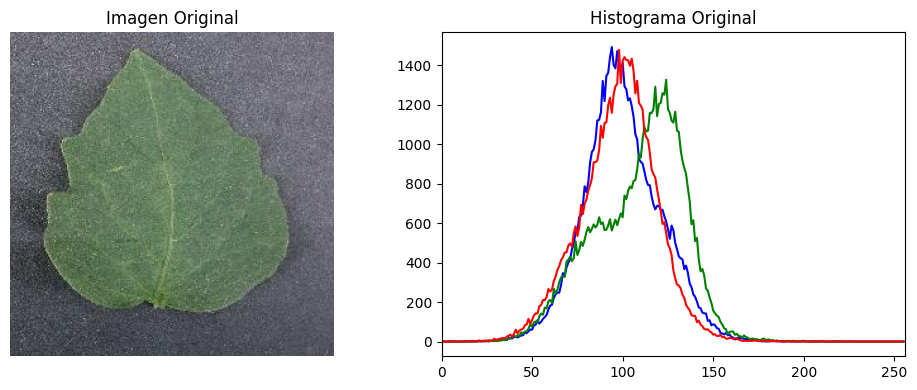

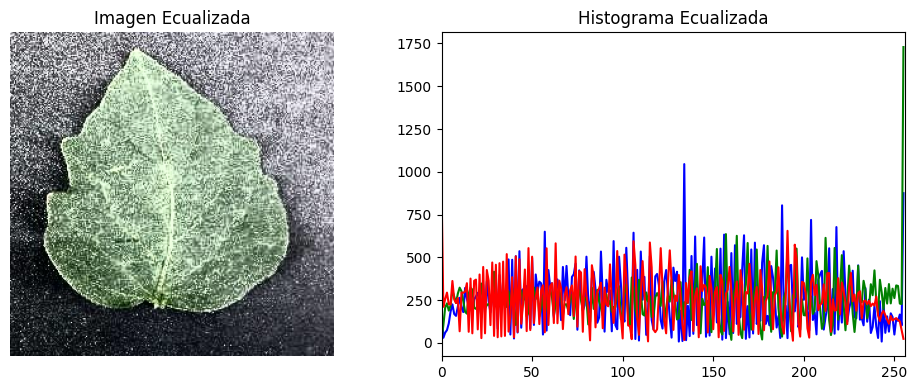

In [ ]:
augmented_paths_buenas = glob(os.path.join(augmented_dir_buenas, '*'))

for path in augmented_paths_buenas:
    img = cv2.imread(path)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # Ecualizar el canal Y
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])

    # Convertir de nuevo a BGR
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    filename = os.path.basename(path)
    cv2.imwrite(os.path.join(equalized_dir_buenas, filename), img_output)

augmented_paths_malas = glob(os.path.join(augmented_dir_malas, '*'))

for path in augmented_paths_malas:
    img = cv2.imread(path)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    # Ecualizar el canal Y
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])

    # Convertir de nuevo a BGR
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    filename = os.path.basename(path)
    cv2.imwrite(os.path.join(equalized_dir_malas, filename), img_output)

print("\n=== Ecualización de Histogramas ===")
sample_aug = cv2.imread(glob(os.path.join(augmented_dir_buenas, '*'))[0])
img_yuv = cv2.cvtColor(sample_aug, cv2.COLOR_BGR2YUV)

# Mostrar histograma antes
plot_histogram(sample_aug, 'Original')

# Ecualizar
img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

# Mostrar histograma después
plot_histogram(img_eq, 'Ecualizada')

### Filtros de suavizado

Aquí se aplican filtros para suavizar el ruido (como el gaussiano y el de mediana) o para resaltar detalles y texturas importantes (como el filtro de realce). Esto permite mejorar la visibilidad de patrones clave como manchas, venas o bordes irregulares en las hojas.


=== Filtrado de Imágenes ===


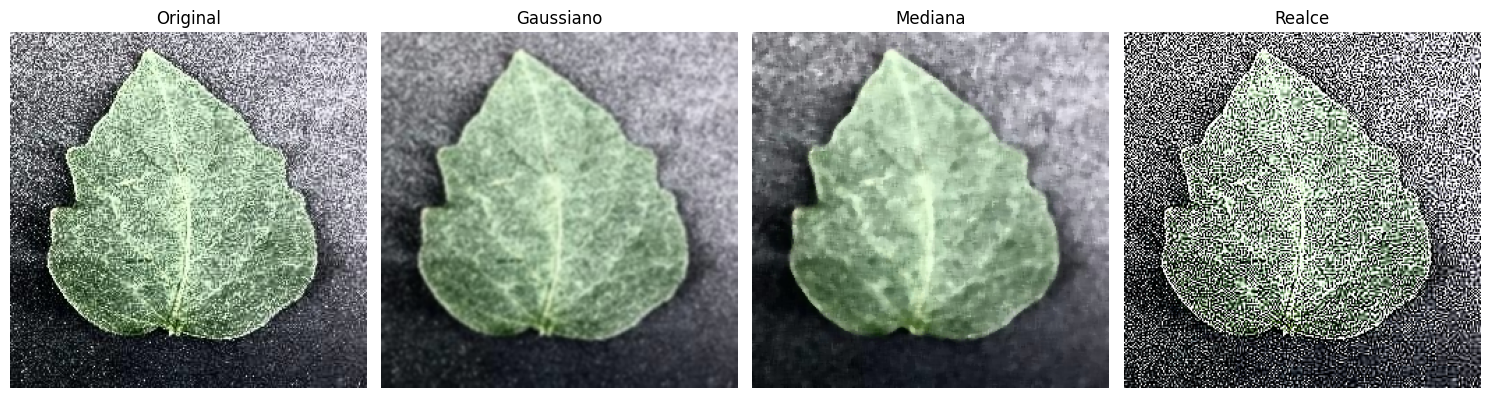

In [ ]:
equalized_paths_buenas = glob(os.path.join(equalized_dir_buenas, '*'))

for path in equalized_paths_buenas:
    img = cv2.imread(path)
    filename = os.path.splitext(os.path.basename(path))[0]

    # Filtro Gaussiano
    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    cv2.imwrite(os.path.join(filtered_dir_buenas, f'{filename}_gauss.jpg'), gauss)

    # Filtro de Mediana
    median = cv2.medianBlur(img, 5)
    cv2.imwrite(os.path.join(filtered_dir_buenas, f'{filename}_median.jpg'), median)

    # Filtro de Realce (Sharpen)
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpen)
    cv2.imwrite(os.path.join(filtered_dir_buenas, f'{filename}_sharpen.jpg'), sharpened)


equalized_paths_malas = glob(os.path.join(equalized_dir_malas, '*'))

for path in equalized_paths_malas:
    img = cv2.imread(path)
    filename = os.path.splitext(os.path.basename(path))[0]

    # Filtro Gaussiano
    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    cv2.imwrite(os.path.join(filtered_dir_malas, f'{filename}_gauss.jpg'), gauss)

    # Filtro de Mediana
    median = cv2.medianBlur(img, 5)
    cv2.imwrite(os.path.join(filtered_dir_malas, f'{filename}_median.jpg'), median)

    # Filtro de Realce (Sharpen)
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1, 5, -1],
                               [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel_sharpen)
    cv2.imwrite(os.path.join(filtered_dir_malas, f'{filename}_sharpen.jpg'), sharpened)

print("\n=== Filtrado de Imágenes ===")
sample_eq = cv2.imread(glob(os.path.join(equalized_dir_buenas, '*'))[0])

# Aplicar filtros
gauss = cv2.GaussianBlur(sample_eq, (5, 5), 0)
median = cv2.medianBlur(sample_eq, 5)
kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened = cv2.filter2D(sample_eq, -1, kernel_sharpen)

# Mostrar resultados
images = [sample_eq, gauss, median, sharpened]
titles = ['Original', 'Gaussiano', 'Mediana', 'Realce']

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


### Deteccion de bordes y umbralizacion

Se extraen los bordes de las hojas de las plantas y se aplica umbralización para obtener representaciones más nítidas que faciliten la clasificación.


=== Detección de Bordes ===


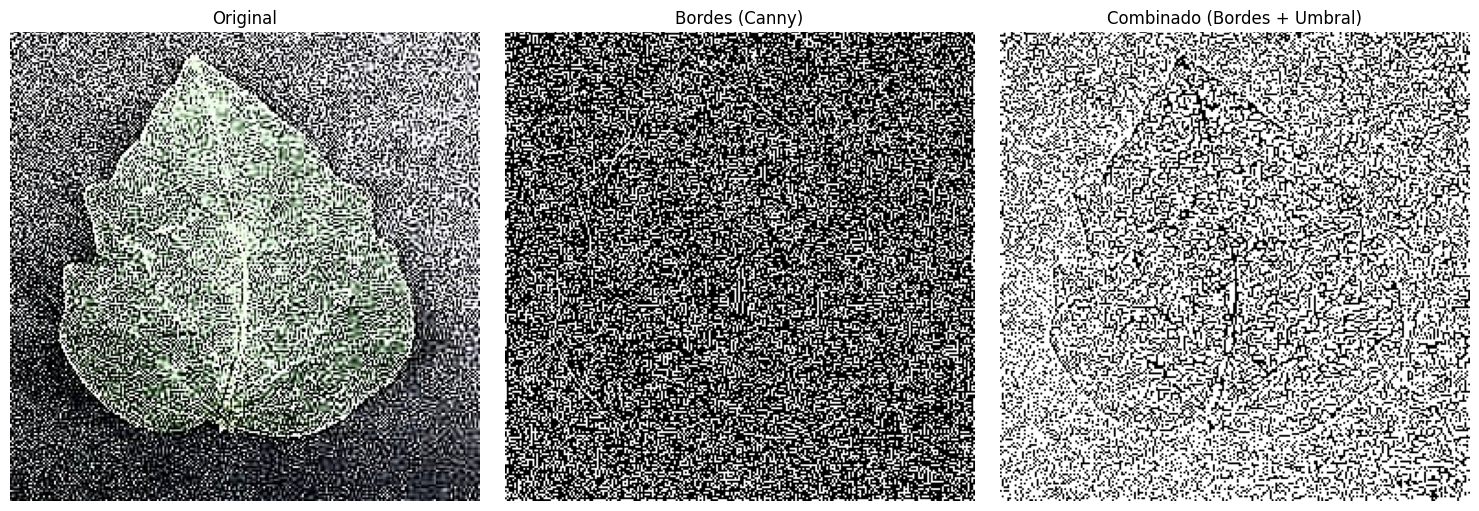

In [ ]:
bordes_dir_buenas = 'imagenes_bordes_buenas/'
bordes_dir_malas = 'imagenes_bordes_malas/'
os.makedirs(bordes_dir_buenas, exist_ok=True)
os.makedirs(bordes_dir_malas, exist_ok=True)

def detectar_bordes_umbral(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ecualizamos ligeramente para más contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = clahe.apply(gray)
    # Canny para bordes
    edges = cv2.Canny(eq, 100, 200)
    # Umbralización adaptativa para segmentar
    thres = cv2.adaptiveThreshold(eq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV, 11, 2)
    combined = cv2.bitwise_or(edges, thres)
    return combined

def procesar_bordes(folder_in, folder_out):
    for img_path in glob(folder_in + '*.jpg'):
        img = cv2.imread(img_path)
        salida = detectar_bordes_umbral(img)
        nombre = os.path.basename(img_path)
        cv2.imwrite(os.path.join(folder_out, nombre), salida)

procesar_bordes(filtered_dir_buenas, bordes_dir_buenas)
procesar_bordes(filtered_dir_malas, bordes_dir_malas)

print("\n=== Detección de Bordes ===")
sample_filtered = cv2.imread(glob(os.path.join(filtered_dir_buenas, '*_sharpen.jpg'))[0])

# Procesar bordes
gray = cv2.cvtColor(sample_filtered, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
eq = clahe.apply(gray)
edges = cv2.Canny(eq, 100, 200)
thres = cv2.adaptiveThreshold(eq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
combined = cv2.bitwise_or(edges, thres)

# Mostrar resultados
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(sample_filtered, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Bordes (Canny)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(combined, cmap='gray')
plt.title('Combinado (Bordes + Umbral)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

def extraer_caracteristicas_bordes(img):
    # Características simples de la imagen de bordes binaria
    total_pixeles = img.size
    pixeles_blancos = np.sum(img == 255)
    densidad_bordes = pixeles_blancos / total_pixeles

    # Momentos de Hu (invariantes a escala, rotación, traslación)
    momentos = cv2.moments(img)
    hu_moments = cv2.HuMoments(momentos).flatten()

    # Devuelve un vector de características
    return np.concatenate([[pixeles_blancos, densidad_bordes], hu_moments])

# Procesar y guardar características
X = []
y = []

for img_path in glob(bordes_dir_buenas + '*.jpg'):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    feats = extraer_caracteristicas_bordes(img)
    X.append(feats)
    y.append(0)  # 0 para buenas

for img_path in glob(bordes_dir_malas + '*.jpg'):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    feats = extraer_caracteristicas_bordes(img)
    X.append(feats)
    y.append(1)  # 1 para malas

# Convertir a DataFrame y guardar
columnas = ['pixeles_blancos', 'densidad_bordes'] + [f'hu_moment_{i+1}' for i in range(7)]
df = pd.DataFrame(X, columns=columnas)
df['etiqueta'] = y
df.to_csv('caracteristicas_bordes.csv', index=False)
print("Características de bordes guardadas en 'caracteristicas_bordes.csv'")
df.head(5)

Características de bordes guardadas en 'caracteristicas_bordes.csv'


pixeles_blancos  densidad_bordes  hu_moment_1   hu_moment_2   hu_moment_3  \
0          26415.0         0.403061     0.000997  4.812289e-11  1.102062e-13   
1          24852.0         0.379211     0.001043  3.849623e-10  6.343348e-13   
2          26982.0         0.411713     0.000987  1.184975e-11  1.707207e-13   
3          24209.0         0.369400     0.000990  3.126569e-10  3.443019e-13   
4          22547.0         0.344040     0.001042  5.364206e-10  1.498497e-12   

    hu_moment_4   hu_moment_5   hu_moment_6   hu_moment_7  etiqueta  
0  5.748642e-14  1.292901e-27  2.259802e-19 -4.389169e-27         0  
1  1.951809e-13  2.928061e-26 -3.626290e-18  6.212296e-26         0  
2  1.828646e-13 -6.451444e-27  4.488105e-19 -3.165940e-26         0  
3  4.480150e-14 -3.002253e-27  2.686622e-19 -4.684829e-27         0  
4  2.594133e-13  7.616470e-26 -5.967108e-18  1.426837e-25         0

### Feature detection y descriptores

Se detectan características clave en las imágenes utilizando algoritmos como SIFT o similares, generando descriptores útiles para entrenar modelos más precisos.


=== Detección de Características (SIFT) ===


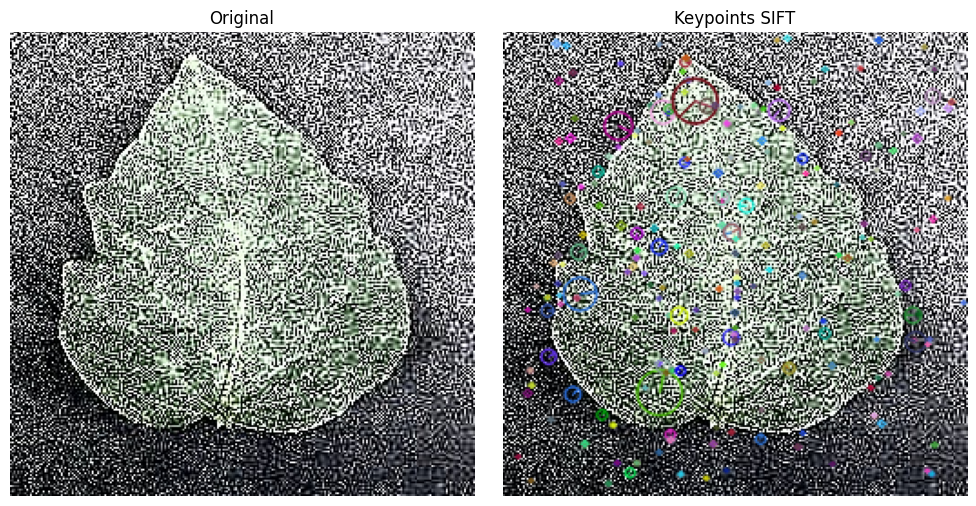

In [ ]:
sift_dir_buenas = 'imagenes_sift_buenas/'
sift_dir_malas = 'imagenes_sift_malas/'
os.makedirs(sift_dir_buenas, exist_ok=True)
os.makedirs(sift_dir_malas, exist_ok=True)

def aplicar_sift(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img_kp = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img_kp

def procesar_sift(folder_in, folder_out):
    for img_path in glob(folder_in + '*.jpg'):
        img = cv2.imread(img_path)
        salida = aplicar_sift(img)
        nombre = os.path.basename(img_path)
        cv2.imwrite(os.path.join(folder_out, nombre), salida)

procesar_sift(filtered_dir_buenas, sift_dir_buenas)
procesar_sift(filtered_dir_malas, sift_dir_malas)

print("\n=== Detección de Características (SIFT) ===")
sample_for_sift = cv2.imread(glob(os.path.join(filtered_dir_buenas, '*_sharpen.jpg'))[0])

# Aplicar SIFT
gray = cv2.cvtColor(sample_for_sift, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
img_kp = cv2.drawKeypoints(sample_for_sift, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Mostrar resultados
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(sample_for_sift, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
plt.title('Keypoints SIFT')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def extraer_descriptores_promedio(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    if des is not None:
        return np.mean(des, axis=0)  # Vector de 128 dimensiones
    else:
        return np.zeros(128)  # Si no detecta descriptores

X_sift = []
y_sift = []

# Buenas
for img_path in glob(filtered_dir_buenas + '*.jpg'):
    img = cv2.imread(img_path)
    desc = extraer_descriptores_promedio(img)
    X_sift.append(desc)
    y_sift.append(0)

# Malas
for img_path in glob(filtered_dir_malas + '*.jpg'):
    img = cv2.imread(img_path)
    desc = extraer_descriptores_promedio(img)
    X_sift.append(desc)
    y_sift.append(1)

# Guardar en CSV
df_sift = pd.DataFrame(X_sift, columns=[f'sift_{i+1}' for i in range(128)])
df_sift['etiqueta'] = y_sift
df_sift.to_csv('caracteristicas_sift.csv', index=False)

print("Características SIFT guardadas en 'caracteristicas_sift.csv'")
df_sift.head(5)

Características SIFT guardadas en 'caracteristicas_sift.csv'


sift_1     sift_2     sift_3     sift_4     sift_5     sift_6  \
0  26.628378  25.864864  25.880220  25.595209  22.893734  18.148649   
1  27.965065  24.673944  22.774382  20.861717  18.735081  16.988356   
2  26.519299  25.884211  24.596491  23.996490  24.336842  22.968422   
3  29.013308  25.586185  24.117237  24.474651  22.474651  17.626108   
4  29.825302  23.968374  20.468374  21.355421  18.239458  14.420180   

      sift_7     sift_8     sift_9    sift_10  ...   sift_120   sift_121  \
0  17.486486  19.990786  47.765972  37.462532  ...  28.758600  24.811424   
1  17.344978  21.324600  53.139736  35.323143  ...  27.711790  23.163027   
2  21.722807  22.575439  47.792984  33.091228  ...  29.845613  26.810526   
3  18.340303  22.179976  51.262356  37.255386  ...  28.714828  23.709759   
4  16.108435  22.802711  62.293674  36.802711  ...  27.260542  23.189758   

    sift_122   sift_123   sift_124   sift_125   sift_126   sift_127  \
0  25.102579  25.074938  25.049755  25.065111  19.553440  17.428747   
1  24.058224  25.764193  25.982533  23.097525  18.577875  15.368268   
2  26.529825  25.954386  25.312281  26.992983  27.505262  23.814035   
3  25.415083  25.134981  25.792776  25.179340  19.159697  18.258554   
4  24.216867  24.768072  26.308735  23.543674  17.281626  15.109940   

    sift_128  etiqueta  
0  19.441647         0  
1  17.387190         0  
2  22.950878         0  
3  18.873892         0  
4  16.590361         0  

[5 rows x 129 columns]

In [ ]:
# Cargar características
df_bordes = pd.read_csv('caracteristicas_bordes.csv')
df_sift = pd.read_csv('caracteristicas_sift.csv')

# Verificamos que los datos tengan las mismas etiquetas en el mismo orden
assert all(df_bordes['etiqueta'] == df_sift['etiqueta']), "Las etiquetas no coinciden entre archivos"

# Unir las características
df_combinado = pd.concat([df_bordes.drop(columns='etiqueta'), df_sift], axis=1)

X = df_combinado.drop(columns='etiqueta').values
y = df_combinado['etiqueta'].values

### Pipeline y optimizacion de hiperparametros

Esta sección define un flujo completo de procesamiento y clasificación, incluyendo la selección de características, el modelo de clasificación y la búsqueda de los mejores hiperparámetros.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

RANDOM_STATE = 42  # para reproducibilidad

# Pipelines con modelos nuevos
pipelines_nuevos = {
    'logreg': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=3000))
    ]),
    'gb': Pipeline([
        ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
    ]),
    'nb': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GaussianNB())
    ]),
    'mlp': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(random_state=RANDOM_STATE, max_iter=3000))
    ]),
    'et': Pipeline([
        ('clf', ExtraTreesClassifier(random_state=RANDOM_STATE))
    ])
}

# Hiperparámetros a explorar para cada modelo
param_distributions_nuevos = {
    'logreg': {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'saga']
    },
    'gb': {
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.1, 0.2],
        'clf__max_depth': [3, 5, 7],
        'clf__subsample': [0.6, 0.8, 1.0]
    },
    'nb': {
        # GaussianNB casi no tiene hiperparámetros relevantes, pero incluimos uno
        'clf__var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'mlp': {
        'clf__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'clf__activation': ['relu', 'tanh'],
        'clf__solver': ['adam'],
        'clf__alpha': [0.0001, 0.001, 0.01]
    },
    'et': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10]
    }
}

In [ ]:
from sklearn.model_selection import train_test_split

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import joblib

# Crear carpeta para guardar los modelos
os.makedirs('modelos_entrenados', exist_ok=True)

resultados_modelos = {}

for nombre, pipeline in pipelines_nuevos.items():
    print(f"\nEntrenando modelo: {nombre}")
    
    # Configurar búsqueda aleatoria de hiperparámetros
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions_nuevos[nombre],
        n_iter=10,
        cv=5,
        scoring='roc_auc',
        verbose=1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    # Predecir y evaluar
    y_pred = search.best_estimator_.predict(X_test)
    reporte = classification_report(y_test, y_pred, output_dict=True)
    
    resultados_modelos[nombre] = {
        'mejor_pipeline': search.best_estimator_,
        'mejores_params': search.best_params_,
        'reporte': reporte
    }
    
    # Guardar el modelo entrenado
    modelo_path = os.path.join('modelos_entrenados', f'modelo_{nombre}.joblib')
    joblib.dump(search.best_estimator_, modelo_path)
    print(f"Modelo {nombre} guardado en {modelo_path}")
    
    # Mostrar el reporte
    print(f"\nReporte para {nombre}:\n")
    print(classification_report(y_test, y_pred))


Entrenando modelo: logreg
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo logreg guardado en modelos_entrenados\modelo_logreg.joblib

Reporte para logreg:

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      2384
           1       0.86      0.82      0.84      2407

    accuracy                           0.84      4791
   macro avg       0.84      0.84      0.84      4791
weighted avg       0.84      0.84      0.84      4791


Entrenando modelo: gb
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo gb guardado en modelos_entrenados\modelo_gb.joblib

Reporte para gb:

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2384
           1       0.93      0.92      0.93      2407

    accuracy                           0.93      4791
   macro avg       0.93      0.93      0.93      4791
weighted avg       0.93      0.93      0.93      4791


Entrena

c:\Users\alejo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Modelo nb guardado en modelos_entrenados\modelo_nb.joblib

Reporte para nb:

              precision    recall  f1-score   support

           0       0.64      0.92      0.75      2384
           1       0.86      0.48      0.62      2407

    accuracy                           0.70      4791
   macro avg       0.75      0.70      0.68      4791
weighted avg       0.75      0.70      0.68      4791


Entrenando modelo: mlp
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo mlp guardado en modelos_entrenados\modelo_mlp.joblib

Reporte para mlp:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2384
           1       0.96      0.94      0.95      2407

    accuracy                           0.95      4791
   macro avg       0.95      0.95      0.95      4791
weighted avg       0.95      0.95      0.95      4791


Entrenando modelo: et
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Modelo et guardado e

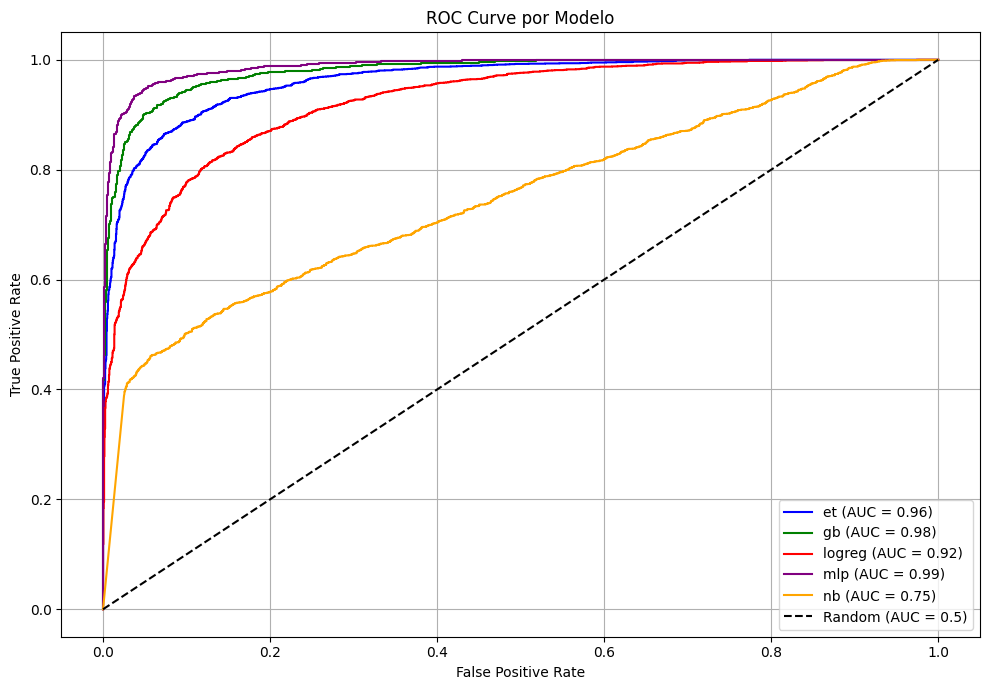

In [ ]:
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Carpeta donde están guardados los modelos
modelos_path = 'modelos_entrenados'

# Colores para el gráfico
colores = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(10, 7))

for i, nombre_modelo in enumerate(os.listdir(modelos_path)):
    if nombre_modelo.endswith('.joblib'):
        nombre = nombre_modelo.replace('modelo_', '').replace('.joblib', '')
        
        # Cargar el modelo
        modelo = joblib.load(os.path.join(modelos_path, nombre_modelo))
        
        # Obtener probabilidades para clase positiva (asumiendo clases binarias 0 vs 1)
        y_proba = modelo.predict_proba(X_test)[:, 1]
        
        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        # Graficar
        plt.plot(fpr, tpr, color=colores[i % len(colores)], label=f"{nombre} (AUC = {auc:.2f})")

# Diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

plt.title('ROC Curve por Modelo')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

best_auc = 0
best_model = None
best_model_name = ""
modelos_path = 'modelos_entrenados'

for nombre_modelo in os.listdir(modelos_path):
    if nombre_modelo.endswith('.joblib'):
        nombre = nombre_modelo.replace('modelo_', '').replace('.joblib', '')
        modelo = joblib.load(os.path.join(modelos_path, nombre_modelo))
        y_proba = modelo.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)

        if auc > best_auc:
            best_auc = auc
            best_model = modelo
            best_model_name = nombre

# === Final Evaluation ===
print(f"\nBest model: {best_model_name} (AUC = {best_auc:.4f})")

y_pred = best_model.predict(X_test)

# Metrics
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


Best model: mlp (AUC = 0.9881)

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2384
           1       0.96      0.94      0.95      2407

    accuracy                           0.95      4791
   macro avg       0.95      0.95      0.95      4791
weighted avg       0.95      0.95      0.95      4791


=== Confusion Matrix ===
[[2279  105]
 [ 147 2260]]

Accuracy: 0.9474


In [ ]:
import os
import cv2
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score

# Función de extracción (HSV histogram, bins ajustables)
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Clasificación de imagen nueva
def clasificar_imagen(img_path, model, label_names):
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ No se pudo leer la imagen: {img_path}")
        return
    features = extract_color_histogram(img)
    features = features.reshape(1, -1)
    pred = model.predict(features)[0]
    proba = model.predict_proba(features)[0]

    print(f"\n📷 Imagen: {img_path}")
    print(f"✅ Predicción: {label_names[pred]}")
    for i, prob in enumerate(proba):
        print(f"  - Probabilidad {label_names[i]}: {prob:.4f}")

# === Buscar el mejor modelo ===
modelos_path = 'modelos_entrenados'
best_auc = 0
best_model = None
best_model_name = ""

# Debes tener tus datos originales aquí para y_test, X_test
# que deben haber sido vectorizados con extract_color_histogram
for nombre_modelo in os.listdir(modelos_path):
    if nombre_modelo.endswith('.joblib'):
        nombre = nombre_modelo.replace('modelo_', '').replace('.joblib', '')
        modelo = joblib.load(os.path.join(modelos_path, nombre_modelo))
        y_proba = modelo.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_proba[:, 1])
        if auc > best_auc:
            best_auc = auc
            best_model = modelo
            best_model_name = nombre

print(f"\n🏆 Mejor modelo: {best_model_name} (AUC = {best_auc:.4f})")

# === Clasificar una hoja sana y una enferma ===
img_sana = "ruta/a/hoja_sana.jpg"
img_enferma = "ruta/a/hoja_enferma.jpg"

# Si tus clases están codificadas como 0 = buena, 1 = mala:
label_names = ["Hoja Sana", "Hoja Enferma"]

clasificar_imagen(img_sana, best_model, label_names)
clasificar_imagen(img_enferma, best_model, label_names)

NameError: name 'X_test' is not defined